In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Loading And Displaying Data Table

In [4]:
# load the csv
csv_path = 'time_series_covid19_confirmed_US.csv'
csv = pd.read_csv(csv_path)
#check the data
csv

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,2212,2230,2242,2267,2283,2304,2328,2351,2385,2417
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,7061,7097,7134,7188,7226,7263,7348,7409,7454,7523
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1079,1080,1090,1092,1095,1098,1107,1112,1113,1117
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,897,907,917,924,926,932,948,961,966,973
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,2188,2222,2253,2286,2297,2335,2378,2400,2429,2488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,873,897,922,932,977,1007,1022,1025,1066,1108
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,518,529,542,544,551,568,614,627,664,686
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,175,179,188,185,187,190,197,199,203,206


## Extract State Arrays

In [5]:
# extract the list of columns
columns = list(csv.columns)
# daily data are after column 11
days = columns[11:]

In [6]:
def get_state_arr(state, days):
    # restrict to your state's data
    csv_state = csv[csv['Province_State'] == state]
    # find the new daily cases
    daily_new_cases = []
    prev_sum = 0
    for day in days:
        counties_sum = 0
        for county in csv_state[day]:
            counties_sum += county
        
        daily_new_cases.append(counties_sum - prev_sum)
        prev_sum = counties_sum
        state_arr = np.asarray(daily_new_cases)
        state_arr = state_arr/(np.max(abs(state_arr)))
    return state_arr

### Function to remove 7 day moving average from data

In [7]:
def rem_window_avg(state, W):
    state_w = np.zeros((297))
    for n in range(len(state)):
        no = np.max([1, n-W+1])
        state_n = np.sum(state[no:n])
        state_w[n] = state_n/(W)
    state_rem_w = state-state_w
    return state_rem_w

## Stack state data into weekly array

In [8]:
states = np.array(["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", 
                   "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", 
                   "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", 
                   "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", 
                   "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
                   "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", 
                   "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"])

In [9]:
#Calculate state arrays for each state
US = []
for i in range(51):
    US.append(get_state_arr(states[i],days))
print(len(US))

51


In [12]:
#Calculate state data with moving averages removed
US_W_N = np.zeros((51, 297))
for i in range(len(states)):
    US_W_N[i] = rem_window_avg(US[i], 7)
    

In [13]:
#Use moving average removed data to get a flat array of covid data from all states

USlong = []
for c in range(51):
    statea = US_W_N[c,:]
    for i in range(294):
        USlong.append(statea[i])
#USflat = [val for sublist in USlong for val in sublist]
    
print(len(USlong))

14994


51
[0. 0. 0. 0. 0. 0. 0.]
(2142, 7)


Text(0.5, 0, 'Day of the Week (0=Wednesday)')

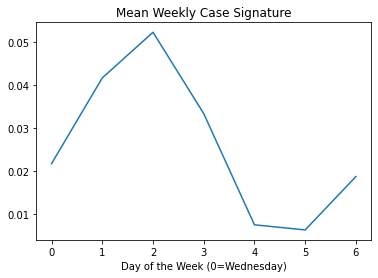

In [14]:
#Stack flat array into full 2142 x 7 array 
print(len(states))
USweekly = np.zeros((2142,7))
print(USweekly[1,:])

for i in range(2142):
    USweekly[i,:] = USlong[i*7:i*7+7]
    
#Remove the mean of each row 
USmu = np.mean(USweekly, 0)
USmr = USweekly - USmu
print(USmr.shape)

#Plot the mean weekly case behavior
plt.plot(USmu)
plt.title("Mean Weekly Case Signature")
plt.xlabel("Day of the Week (0=Wednesday)")

## Perform PCA on the full-country data

(2142, 2142)


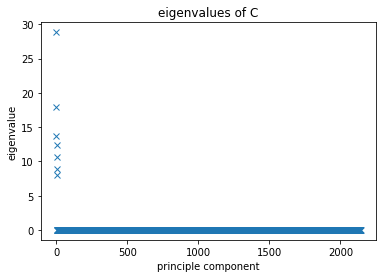

In [15]:
#Calculate covariance matrix, as well as eigenvectors and eigenvalues for full matrix
C = USmr@USmr.T
print(C.shape)
D,U = np.linalg.eig(C)
plt.plot(D,'x')
plt.ylabel('eigenvalue')
plt.xlabel('principle component')
plt.title('eigenvalues of C')
plt.show()

(2142, 7)


Text(0.5, 0, 'Day of the Week (0=Wednesday)')

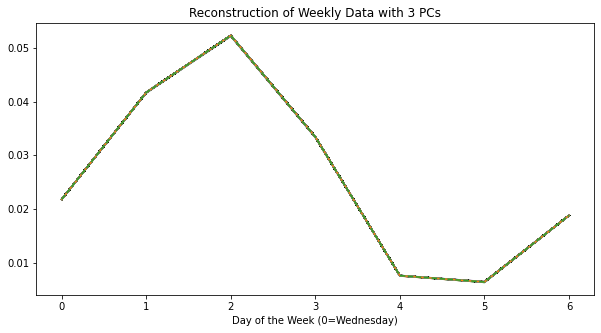

In [16]:
#Try reconstructing weekly data with top 3 eigenvectors:

#Set my projection matrix W to have the 3 largest eigenvectors:
seg = range(0,3)
W = U[seg,:]
Y = W@USmr

#Reconstruct X with 3 eigenvectors:
Xrecon = np.transpose(W)@Y
#Add the mean back
Xrecon = (np.transpose(W)@Y) + USmu
print(Xrecon.shape)

plt.figure(figsize=(10,5))
plt.plot(Xrecon.T)
   

#Calculate mean reconstruction
meanrecon = np.mean(Xrecon, 0)
plt.plot(meanrecon, linestyle = 'dashed')
plt.title("Reconstruction of Weekly Data with 3 PCs")
plt.xlabel("Day of the Week (0=Wednesday)")


## Project Data onto Eigenvectors to Look for Clustering

In [17]:
#Perform SVD in order to obtain appropriately sized W matrix of eigenvectors
U, S, W = np.linalg.svd(USmr)
W = W.T

In [18]:
#Try some projections onto eigenvectors:

#Start with the top 2 eigenvalues:
#print(U.shape)
V = W[:,0:2]
print(V.shape)

#try projecting:
print(USweekly.shape)
USproj = (V.T)@USmr.T
print(USproj.shape)



(7, 2)
(2142, 7)
(2, 2142)


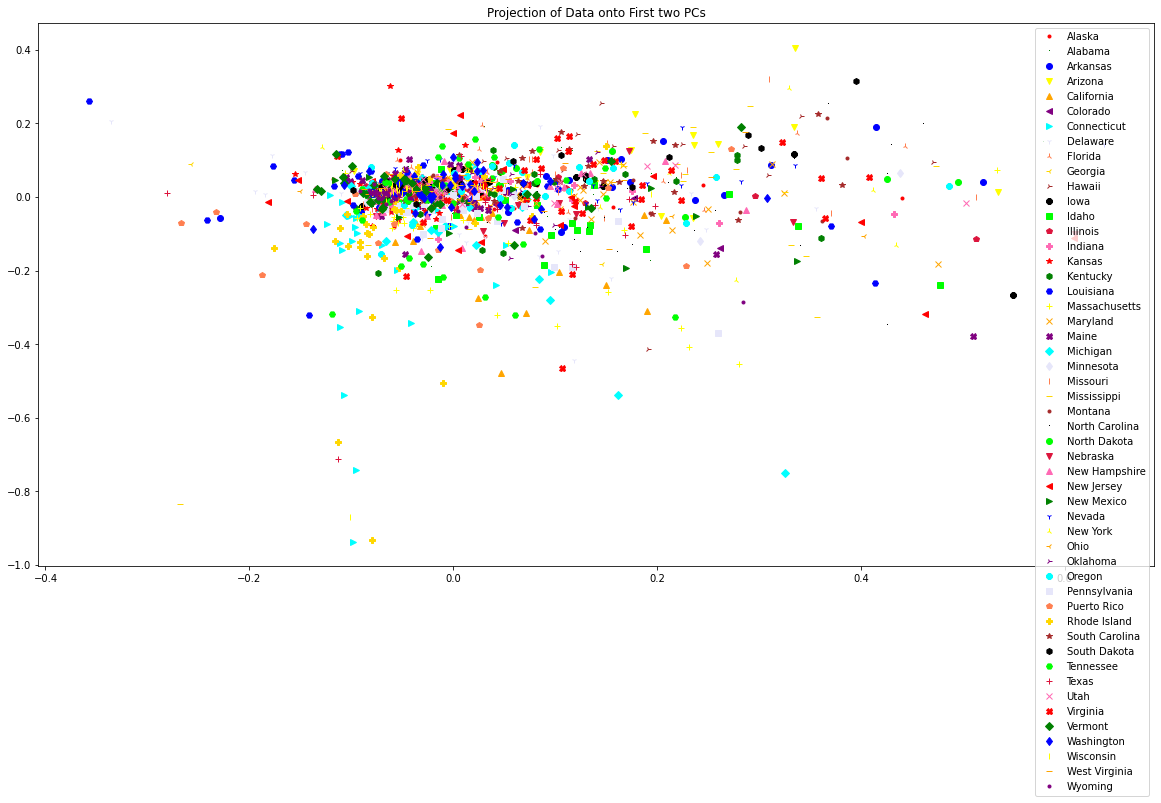

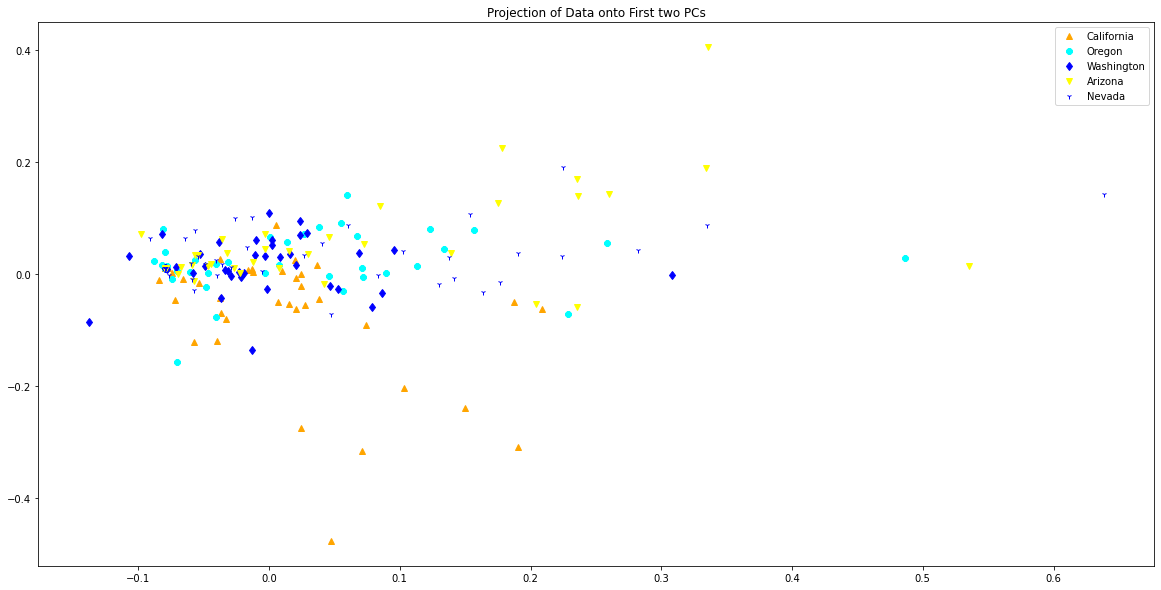

In [20]:
#Write a function to just plot the projections of states we want:

#Separate out the x and y vars by state so that we can plot different states with different colors easily
xars = []
yars = []
for i in range(51):
    xars.append(USproj[0, 42*i:42*(i+1)])
    yars.append(USproj[1, 42*i:42*(i+1)])
    

states = list(states)
def plot_projections(stateslist):
    colors = ['red','green','blue','yellow','orange', 'purple', 'aqua','lavender', 'coral', 'gold', 'brown', 'black', 
           'lime', 'crimson', 'hotpink', 'red','green','blue','yellow','orange', 'purple', 'aqua','lavender', 'coral', 
            'gold', 'brown', 'black', 'lime', 'crimson', 'hotpink','red','green','blue','yellow','orange', 'purple', 
            'aqua','lavender', 'coral', 'gold', 'brown', 'black', 'lime', 'crimson', 'hotpink', 'red', 'green','blue',
            'yellow','orange','purple']

    symbols = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",
          ".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_","."]    

    legend = []
    plt.figure(figsize=(20,10))
    for state in stateslist:
        sindex = states.index(state)
        legend.append(state)
        plt.plot(xars[sindex],yars[sindex],symbols[sindex], color = colors[sindex])
    plt.legend(legend, loc = 'upper right')
    plt.title("Projection of Data onto First two PCs")
    #plt.xlim(-2000,8000)
    #plt.ylim(-10000,10000)
    
        
#Plot all of the states        
plot_projections(states)

#Plot a few Western states
west = ['California','Oregon','Washington','Arizona','Nevada']
plot_projections(west)



